# **주요 내용**

*   실험

In [1]:
notebookName = "20200518"
notebookName

'20200518'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**plot working time & validation loss and accuracy**

In [0]:
import numpy as np
import os

result_path = "/content/drive/My Drive/results"
history  = np.load(os.path.join(result_path, "20200513_11.npz"))

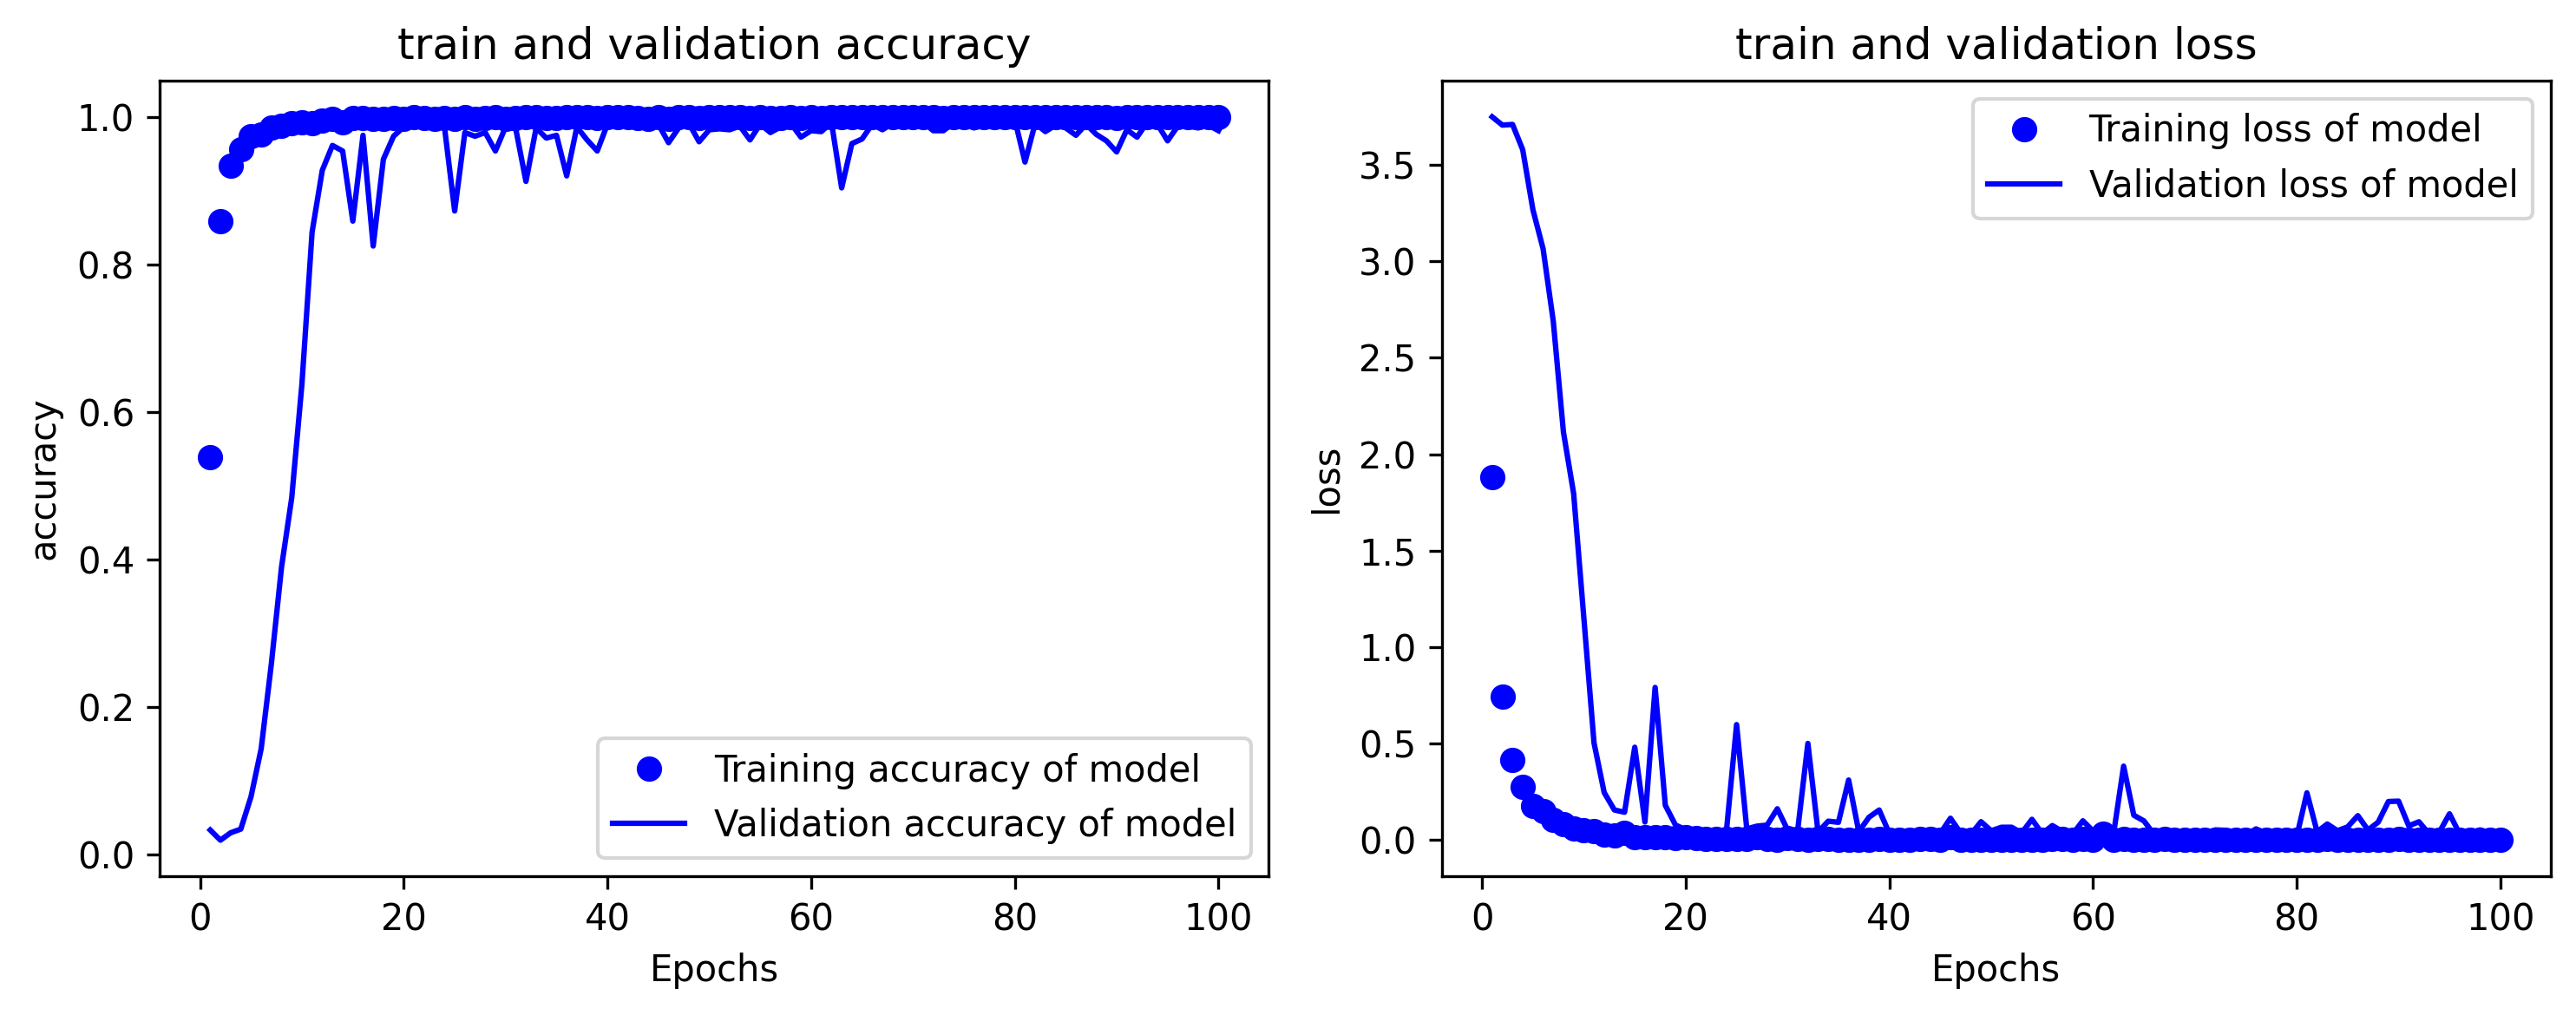

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

acc = history['accuracy'][:100]
val_acc = history['val_accuracy'][:100]
loss = history['loss'][:100]
val_loss = history['val_loss'][:100]

# accuracy
plt.subplot(1, 2, 1)

plt.plot(np.arange(1, len(acc) + 1, 1), acc, 'bo', label = 'Training accuracy of model')
plt.plot(np.arange(1, len(val_acc) + 1, 1), val_acc, 'b', label = 'Validation accuracy of model')

plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(np.arange(1, len(loss) + 1, 1), loss, 'bo', label = 'Training loss of model')
plt.plot(np.arange(1, len(val_loss) + 1, 1), val_loss, 'b', label = 'Validation loss of model')

plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
import numpy as np

model_names = np.array([["without_sfconv_{}".format(i), "sfconv_ks2_{}".format(i), "sfconv_ks3_{}".format(i), "sfconv_ks5_{}".format(i)] for i in range(10)])

In [0]:
model_names.shape

In [0]:
model_names = model_names.reshape(10 * 4)

In [0]:
model_names

In [0]:
import numpy as np
import os

previous = "20200517_3"
num_models = 4
num_loop = 10
epochs = 500

working_time = np.zeros((num_models, num_loop))
histories = np.zeros((num_models, num_loop, 4, epochs))

for i, model_name in enumerate(model_names):
    history = np.load(os.path.join("/content/drive/My Drive/results", "{}_{}.npz".format(previous, model_name)))

    histories[i % num_models, i // num_models, 0] = history['accuracy']
    histories[i % num_models, i // num_models, 1] = history['val_accuracy']
    histories[i % num_models, i // num_models, 2] = history['loss']
    histories[i % num_models, i // num_models, 3] = history['val_loss']

    working_time[i % num_models, i // num_models] = history['working_time']

In [0]:
avg_working_time = working_time.mean(axis = 1)
avg_histories = histories.mean(axis = 1)

print(avg_working_time.shape, avg_histories.shape)

In [0]:
mn = ["without sfconv", "sfconv (kernel size = 2)", "sfconv (kernel size = 3)", "sfconv (kernel size = 5)"]

for i in range(num_models):
    print("[{}] avg working time: {:.2f} sec".format(mn[i], avg_working_time[i]))

In [0]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [0]:
import matplotlib.pyplot as plt

def plot_histories(avg_histories):
    fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)
    c = ['r', 'g', 'b', 'm']
    l = ["--", "-", ":", "-."]
    n = ["without sfconv", "sfconv (kernel size = 2)", "sfconv (kernel size = 3)", "sfconv (kernel size = 5)"]

    plt.subplot(1, 2, 1)
    for i, history in enumerate(avg_histories):
        acc = history[0]
        val_acc = history[1]
        plt.plot(np.arange(1, len(val_acc) + 1, 1), 1 - np.array(smooth_curve(val_acc)),
                 color = c[i], label = n[i], alpha = .7, linewidth = 1.5, linestyle = l[i])
    plt.title('Averaged Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.ylim([-0.03, 1.03])
    # plt.yscale('log')
    plt.legend()
    plt.grid(True, linewidth = 0.4)

    plt.subplot(1, 2, 2)
    for i, history in enumerate(avg_histories):
        loss = history[2]
        val_loss = history[3]
        plt.plot(np.arange(1, len(val_loss) + 1, 1), smooth_curve(val_loss),
                 color = c[i], label = n[i], alpha = .7, linewidth = 1.5, linestyle = l[i])
    plt.title('Averaged Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linewidth = 0.4)

    plt.tight_layout()
    plt.show()

In [0]:
plot_histories(avg_histories)

In [0]:
test_labels = np.zeros((1000, 50))
num_labels = 50

In [0]:
preds = np.zeros((num_models, num_loop, test_labels.shape[0], test_labels.shape[1])) # (3, 10, 1000, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    preds[i % num_models, i // num_models] = pred

In [0]:
test_errors = np.zeros((num_models, num_loop))

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)
    
    test_errors[i % num_models, i // num_models] = np.sum(np.not_equal(np.argmax(pred, axis = 1), y)) / test_labels.shape[0]

In [0]:
test_errors

In [0]:
mn = ["without sfconv", "sfconv (kernel size = 2)", "sfconv (kernel size = 3)", "sfconv (kernel size = 5)"]

for i in range(num_models):
    print("[{}] avg test error: {:.4f}".format(mn[i], test_errors[i].mean()))

In [0]:
cmcs = np.zeros((num_models, num_loop, 50)) # (3, 10, 50)

for i, model_name in enumerate(model_names):
    pred = np.load(os.path.join("/content/drive/My Drive/evals", "{}_{}.npy".format(previous, model_name))) # (1000, 50)
    y = np.array(sorted([i for i in range(num_labels)] * 20)) # (1000)

    a = np.array([sorted(pred[j], reverse = True).index(pred[j, y[j]]) for j in range(len(y))]) # 정답의 순위    
    cmcs[i % num_models, i // num_models] = np.array([len(a[a<=j]) / 1000 for j in range(50)])

In [0]:
print(cmcs)

In [0]:
avg_cmcs = cmcs.mean(axis = 1)

fig = plt.figure(figsize = (5, 4), facecolor = 'white', dpi = 300)

for i, model_cmc in enumerate(avg_cmcs):
    c = ['r', 'g', 'b', 'm']
    l = ["--", "-", ":", "-."]
    n = ["without sfconv", "sfconv (kernel size = 2)", "sfconv (kernel size = 3)", "sfconv (kernel size = 5)"]

    plt.plot(np.arange(1, 21, 1), model_cmc[:20],
             color = c[i], label = n[i], alpha = .7, linewidth = 1.5, linestyle = l[i])

plt.title('Averaged Cumulative Match Curve')
plt.xlabel('Rank (k)')
plt.ylabel('Rank-k Recognition Rate')
plt.xticks([1, 5, 10, 20])
plt.legend()
plt.grid(True, linewidth = 0.4)

plt.tight_layout()
plt.show()

In [0]:
mn = ["without sfconv", "sfconv (kernel size = 2)", "sfconv (kernel size = 3)", "sfconv (kernel size = 5)"]

for i, cmc in enumerate(avg_cmcs):
    print("[{}] top 1 error: {:.4f}, top 5 error: {:.4f}".format(mn[i], 1 - cmc[0], 1 - cmc[4]))